In [ ]:
#!pip install transformers diffusers accelerate datasets

In [ ]:
from datasets import load_dataset
dataset = load_dataset("mnist")

# Prepare Dataset

## Load and Examine Dataset

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [ ]:
sample = dataset['train']['image'][0]
sample_label = dataset['train']['label'][0]

In [ ]:
sample, sample_label

(<PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>, 5)

5


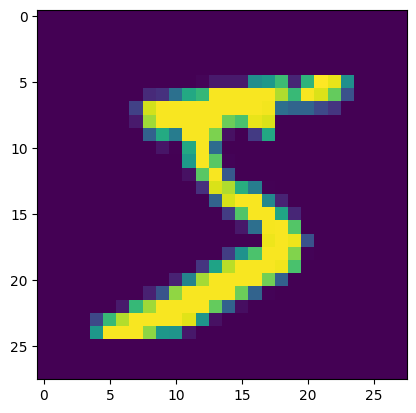

In [ ]:
import matplotlib.pyplot as plt
print(sample_label)
plt.imshow(sample)

## Transform Dataset for Training

In [ ]:
from torchvision import transforms

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Pad(2), ## send the size becomes 32x32
    ## https://pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html
    transforms.Normalize([0.5],[0.5]) ## normalize the range into -1 to 1
])

Check the shape of data after transformation

In [ ]:
import torch
batch_size = 512

def transform(examples):
    ## https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.convert
    ## convert PIL Image to L mode (GrayScale)
    images = [preprocess(image.convert("L")) for image in examples["image"]]

    return {"images":images, "labels":examples["label"]}

train_dataset = dataset['train'].with_transform(transform)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size, shuffle=True
)

In [ ]:
batch = next(iter(train_dataloader))
print('Shape:', batch['images'].shape,
      '\nBounds:', batch['images'].min().item(), 'to', batch['images'].max().item())

Shape: torch.Size([512, 1, 32, 32]) 
Bounds: -1.0 to 1.0


# Build the Model

In [ ]:
from diffusers import UNet2DModel

unet = UNet2DModel(
    in_channels=1,
    out_channels=1,
    sample_size=32,
    block_out_channels=(32,64,128,256),
    norm_num_groups=8,
    num_class_embeds=10
)

Test the inference and the output shape

In [ ]:
noised_x = torch.randn((1, 1, 32, 32))
with torch.no_grad():
    out = unet(noised_x, timestep=7, class_labels=torch.tensor([2])).sample

out.shape

torch.Size([1, 1, 32, 32])

# Training

In [ ]:
import torch.nn.functional as F
from tqdm import tqdm

from diffusers import DDPMScheduler

def train(num_epochs=30, lr=1e-4, device="cuda"):
    scheduler = DDPMScheduler(num_train_timesteps=1000, beta_start=0.0001, beta_end=0.02)
    optimizer = torch.optim.AdamW(unet.parameters(), lr=lr) # The optimizer
    losses = [] # somewhere to store the loss values for later plotting
    unet.to(device)

    # Train the model (this takes a while!)
    for epoch in range(num_epochs):
        for step, batch in tqdm(enumerate(train_dataloader)):

            # Load the input images
            clean_images = batch["images"].to(device)
            class_labels = batch["labels"].to(device)

            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape).to(clean_images.device)

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0,
                scheduler.config.num_train_timesteps,
                (clean_images.shape[0],),
                device=clean_images.device,
            ).long()

            # Add noise to the clean images according timestep
            noisy_images = scheduler.add_noise(clean_images, noise, timesteps)

            # Get the model prediction for the noise
            noise_pred = unet(noisy_images, timesteps, class_labels=class_labels, return_dict=False)[0]

            # Compare the prediction with the actual noise:
            loss = F.mse_loss(noise_pred, noise)
            losses.append(loss)
            # Store the loss for later plotting
            # Update the model parameters with the optimizer based on this loss
            loss.backward(loss)
            optimizer.step()
            optimizer.zero_grad()
        print(f"Epoch {epoch}: loss={losses[-1]}")
    return losses

In [ ]:
losses = train()

118it [02:54,  1.48s/it]


Epoch 0: loss=0.134923055768013


118it [02:58,  1.51s/it]


Epoch 1: loss=0.09349332749843597


118it [02:54,  1.48s/it]


Epoch 2: loss=0.08443140983581543


118it [02:55,  1.48s/it]


Epoch 3: loss=0.07788047194480896


118it [02:55,  1.49s/it]


Epoch 4: loss=0.058717504143714905


118it [02:55,  1.49s/it]


Epoch 5: loss=0.06369702517986298


118it [02:55,  1.49s/it]


Epoch 6: loss=0.06044081971049309


118it [02:54,  1.48s/it]


Epoch 7: loss=0.05397258698940277


118it [02:55,  1.48s/it]


Epoch 8: loss=0.04751846194267273


118it [02:54,  1.48s/it]


Epoch 9: loss=0.02840113639831543


118it [02:54,  1.48s/it]


Epoch 10: loss=0.030228029936552048


118it [02:54,  1.48s/it]


Epoch 11: loss=0.03778734430670738


118it [02:55,  1.48s/it]


Epoch 12: loss=0.03324490785598755


118it [02:54,  1.48s/it]


Epoch 13: loss=0.028056636452674866


118it [02:54,  1.48s/it]


Epoch 14: loss=0.029395490884780884


118it [02:55,  1.48s/it]


Epoch 15: loss=0.032923147082328796


118it [02:53,  1.47s/it]


Epoch 16: loss=0.03403869643807411


118it [02:51,  1.46s/it]


Epoch 17: loss=0.026324141770601273


118it [02:52,  1.46s/it]


Epoch 18: loss=0.03729403764009476


118it [02:52,  1.46s/it]


Epoch 19: loss=0.02556244656443596


118it [02:51,  1.46s/it]


Epoch 20: loss=0.027926942333579063


118it [02:51,  1.46s/it]


Epoch 21: loss=0.03226643428206444


118it [02:52,  1.46s/it]


Epoch 22: loss=0.029998864978551865


118it [02:51,  1.46s/it]


Epoch 23: loss=0.024523979052901268


118it [02:51,  1.46s/it]


Epoch 24: loss=0.02717258408665657


75it [01:50,  1.48s/it]


OutOfMemoryError: ignored

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)

# Upload to HuggingFace

In [ ]:
!pip install huggingface_hub

In [ ]:
from huggingface_hub import notebook_login

In [ ]:
notebook_login()

In [ ]:
unet.push_to_hub("unet-mnist-32", variant="fp16")

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/63.6M [00:00<?, ?B/s]

'https://huggingface.co./gnokit/unet-mnist-32/tree/main/'

In [ ]:
UNet2DModel.from_pretrained("gnokit/unet-mnist-32", use_safetensors=True, variant="fp16").to("cuda")

config.json:   0%|          | 0.00/965 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/63.6M [00:00<?, ?B/s]

UNet2DModel(
  (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): LoRACompatibleLinear(in_features=32, out_features=128, bias=True)
    (act): SiLU()
    (linear_2): LoRACompatibleLinear(in_features=128, out_features=128, bias=True)
  )
  (class_embedding): Embedding(10, 128)
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(8, 32, eps=1e-05, affine=True)
          (conv1): LoRACompatibleConv(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): LoRACompatibleLinear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(8, 32, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): LoRACompatibleConv(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
 